In [29]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_lg
import spacy 
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases


In [2]:
# load the data
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
# df_submission = pd.read_csv('./submission_file.csv')

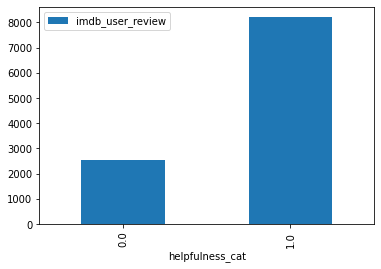

In [5]:
# check the distribution of the dataset by category
df_train.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

In [6]:
df_test.head()

,_id,imdb_user_review
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...


In [3]:
nlp = spacy.load("en_core_web_lg")

In [8]:
gist_file = open("gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    stopwords = content.split(",")
finally:
    gist_file.close()
    
stopwords=[i.replace('"',"").strip() for i in stopwords]

In [9]:
len(stopwords)

1160

In [10]:
for i in stopwords:
  nlp.Defaults.stop_words.add("stopwords")

In [11]:
nlp.Defaults.stop_words |= {"a","b","c","d","e","f","g","h","j","k","l","m","n"}

In [12]:
# separate x and y
review_text = df_train['imdb_user_review']
review_cat = df_train['helpfulness_cat']

### Preprocessing text

In [13]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    stopwords = ["Mr", "Mr.", "$", "Inc.", "year"]
    for item in stopwords:
        nlp.vocab[item].is_stop = True
    # create colloum for cleaned reviews
    reviews_tokens, tmp_tokens = [], [] 
    for review in tqdm.tqdm(reviews):
        tmp_tokens = [
            token.lemma_
            for token in nlp(review)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        reviews_tokens.append(tmp_tokens)
        tmp_tokens=[]
        
    # # convert list back to df 
    # reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

    return reviews_tokens

In [ ]:
train = clean_data(review_text)

Total voc number: 10755


 11%|█▏        | 1225/10755 [00:58<04:58, 31.98it/s]

In [ ]:
# create a dataframe for analysis
reviews = pd.DataFrame({'imbd_user_review':train,'helpfulness_cat':review_cat})

In [ ]:
# build spell checker and create spell mistakes
spell = SpellChecker()
mdy_train, temp_train = [], []
for comment in tqdm.tqdm(train):
    temp_train = [word if word in spell else spell.correction(word) for word in comment]
    mdy_train.append(temp_train)
    temp_train=[]
# spell.word_frequency.remove('aka')

In [ ]:
import pickle
file_name='correct_train2.txt'
with open(file_name, "wb") as fp:   #Pickling
    pickle.dump(mdy_train, fp)

In [ ]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train]

## Feature Enginerring

In [ ]:
# import contextualSpellCheck
# contextualSpellCheck.add_to_pipe(nlp)
# text= ['creaaaation']
# doc = nlp(text)
# print(doc._.performed_spellCheck) #Should be True
# print(doc._.outcome_spellCheck) #Income was $9.4 million compared to the prior year of $2.7 million.

### Topic Modeling

In [7]:
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    mdy_train,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[mdy_train],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased = [trigram[bigram[line]] for line in mdy_train]

In [9]:
# create a corpus using Tomotopy utils
# empty corpus
corpus = tp.utils.Corpus()
# populate the corpus
for item in docs_phrased:
    corpus.add_doc(words=item)


# topic modeling ― explore model validity
# register "UMass" coherence scores
cvs = {}
for topic_number in tqdm.tqdm(range(1, 100, 1)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus)
    for i in range(0, 100, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score()

  0%|          | 0/99 [00:00<?, ?it/s]

Iteration: 0	Log-likelihood: -8.325108936175472
Iteration: 10	Log-likelihood: -8.325108936175472
Iteration: 20	Log-likelihood: -8.325108936175472
Iteration: 30	Log-likelihood: -8.325108936175472
Iteration: 40	Log-likelihood: -8.325108936175472


  1%|          | 1/99 [00:03<06:08,  3.76s/it]

Iteration: 50	Log-likelihood: -8.325108936175472
Iteration: 60	Log-likelihood: -8.325108936175472
Iteration: 70	Log-likelihood: -8.325108936175472
Iteration: 80	Log-likelihood: -8.325108936175472
Iteration: 90	Log-likelihood: -8.325108936175472
Iteration: 0	Log-likelihood: -8.80687741592565
Iteration: 10	Log-likelihood: -8.767114688540383
Iteration: 20	Log-likelihood: -8.689158684182729
Iteration: 30	Log-likelihood: -8.578509668632174
Iteration: 40	Log-likelihood: -8.532075607380849
Iteration: 50	Log-likelihood: -8.51163221322421
Iteration: 60	Log-likelihood: -8.49840005239215
Iteration: 70	Log-likelihood: -8.493794562426757


  2%|▏         | 2/99 [00:07<05:47,  3.59s/it]

Iteration: 80	Log-likelihood: -8.490208500923828
Iteration: 90	Log-likelihood: -8.485039933824545
Iteration: 0	Log-likelihood: -9.036779855033092
Iteration: 10	Log-likelihood: -8.866376106787063
Iteration: 20	Log-likelihood: -8.740205172424275
Iteration: 30	Log-likelihood: -8.680511401056659
Iteration: 40	Log-likelihood: -8.650880813018883
Iteration: 50	Log-likelihood: -8.632076106097003
Iteration: 60	Log-likelihood: -8.616878839976042


  3%|▎         | 3/99 [00:11<06:15,  3.91s/it]

Iteration: 70	Log-likelihood: -8.60925871542489
Iteration: 80	Log-likelihood: -8.603271669214283
Iteration: 90	Log-likelihood: -8.597440062478425
Iteration: 0	Log-likelihood: -9.199329329382156
Iteration: 10	Log-likelihood: -9.003284928730215
Iteration: 20	Log-likelihood: -8.84052141605139
Iteration: 30	Log-likelihood: -8.764358173152658
Iteration: 40	Log-likelihood: -8.720879784125795
Iteration: 50	Log-likelihood: -8.697510971761737
Iteration: 60	Log-likelihood: -8.680264856759244
Iteration: 70	Log-likelihood: -8.666591196468355
Iteration: 80	Log-likelihood: -8.657366004840032


  4%|▍         | 4/99 [00:15<06:27,  4.08s/it]

Iteration: 90	Log-likelihood: -8.64889442926723
Iteration: 0	Log-likelihood: -9.31066934763258
Iteration: 10	Log-likelihood: -9.11828874689425
Iteration: 20	Log-likelihood: -8.980412958558919
Iteration: 30	Log-likelihood: -8.903522919746537
Iteration: 40	Log-likelihood: -8.85160461892329
Iteration: 50	Log-likelihood: -8.817971288570963


  5%|▌         | 5/99 [00:20<06:49,  4.36s/it]

Iteration: 60	Log-likelihood: -8.796384872604227
Iteration: 70	Log-likelihood: -8.778975144458265
Iteration: 80	Log-likelihood: -8.768401023127268
Iteration: 90	Log-likelihood: -8.760615714261622
Iteration: 0	Log-likelihood: -9.380502625397499
Iteration: 10	Log-likelihood: -9.170142010687416
Iteration: 20	Log-likelihood: -9.030035743450096
Iteration: 30	Log-likelihood: -8.944985115805162
Iteration: 40	Log-likelihood: -8.893423020777362
Iteration: 50	Log-likelihood: -8.862960257674214
Iteration: 60	Log-likelihood: -8.837843835576994
Iteration: 70	Log-likelihood: -8.818046763826343
Iteration: 80	Log-likelihood: -8.80112446648538


  6%|▌         | 6/99 [00:25<07:12,  4.65s/it]

Iteration: 90	Log-likelihood: -8.793124874226429
Iteration: 0	Log-likelihood: -9.450690050539635
Iteration: 10	Log-likelihood: -9.230241566067567
Iteration: 20	Log-likelihood: -9.069833641043017
Iteration: 30	Log-likelihood: -8.982357497896514
Iteration: 40	Log-likelihood: -8.924896986360208
Iteration: 50	Log-likelihood: -8.885404470184376
Iteration: 60	Log-likelihood: -8.855151495613148
Iteration: 70	Log-likelihood: -8.836762997613222
Iteration: 80	Log-likelihood: -8.81961006942646


  7%|▋         | 7/99 [00:34<09:06,  5.94s/it]

Iteration: 90	Log-likelihood: -8.803960974567998
Iteration: 0	Log-likelihood: -9.511740514852107
Iteration: 10	Log-likelihood: -9.282575923559422
Iteration: 20	Log-likelihood: -9.100846852597185
Iteration: 30	Log-likelihood: -8.993504120157663
Iteration: 40	Log-likelihood: -8.932409507849927
Iteration: 50	Log-likelihood: -8.891756965263344


  8%|▊         | 8/99 [00:39<08:32,  5.63s/it]

Iteration: 60	Log-likelihood: -8.864559338819669
Iteration: 70	Log-likelihood: -8.84438725072992
Iteration: 80	Log-likelihood: -8.827239708770566
Iteration: 90	Log-likelihood: -8.80653077845674
Iteration: 0	Log-likelihood: -9.528649203768346
Iteration: 10	Log-likelihood: -9.28603835946466
Iteration: 20	Log-likelihood: -9.149582031856047
Iteration: 30	Log-likelihood: -9.065569349834657
Iteration: 40	Log-likelihood: -9.007177699393434
Iteration: 50	Log-likelihood: -8.965804340017597
Iteration: 60	Log-likelihood: -8.936262378994579
Iteration: 70	Log-likelihood: -8.912495373812364
Iteration: 80	Log-likelihood: -8.89647155026442
Iteration: 90	Log-likelihood: -8.88247651844714


  9%|▉         | 9/99 [00:44<07:56,  5.29s/it]

Iteration: 0	Log-likelihood: -9.601218376518558
Iteration: 10	Log-likelihood: -9.388807806509346
Iteration: 20	Log-likelihood: -9.21607372469101
Iteration: 30	Log-likelihood: -9.112060930073817
Iteration: 40	Log-likelihood: -9.04709117632165
Iteration: 50	Log-likelihood: -9.00457060445104


 10%|█         | 10/99 [00:48<07:36,  5.13s/it]

Iteration: 60	Log-likelihood: -8.976751417680848
Iteration: 70	Log-likelihood: -8.95010122533927
Iteration: 80	Log-likelihood: -8.932795209455918
Iteration: 90	Log-likelihood: -8.915110088935966
Iteration: 0	Log-likelihood: -9.612458629067294
Iteration: 10	Log-likelihood: -9.36904564526372
Iteration: 20	Log-likelihood: -9.235176340614483
Iteration: 30	Log-likelihood: -9.147159725883299
Iteration: 40	Log-likelihood: -9.081504242865199
Iteration: 50	Log-likelihood: -9.034639402244188
Iteration: 60	Log-likelihood: -8.996852394595992
Iteration: 70	Log-likelihood: -8.971358458989195
Iteration: 80	Log-likelihood: -8.94741595839056
Iteration: 90	Log-likelihood: -8.930296095027689


 11%|█         | 11/99 [00:54<07:42,  5.25s/it]

Iteration: 0	Log-likelihood: -9.66331019002718
Iteration: 10	Log-likelihood: -9.438344081734444
Iteration: 20	Log-likelihood: -9.277339310231508
Iteration: 30	Log-likelihood: -9.176797029858621
Iteration: 40	Log-likelihood: -9.10786786684227
Iteration: 50	Log-likelihood: -9.066468673944716
Iteration: 60	Log-likelihood: -9.030982553998385
Iteration: 70	Log-likelihood: -9.004799138617582
Iteration: 80	Log-likelihood: -8.978335075076554


 12%|█▏        | 12/99 [01:02<08:43,  6.02s/it]

Iteration: 90	Log-likelihood: -8.962364547568429
Iteration: 0	Log-likelihood: -9.687365811165987
Iteration: 10	Log-likelihood: -9.427044811126166
Iteration: 20	Log-likelihood: -9.271065754120345
Iteration: 30	Log-likelihood: -9.172801906737732
Iteration: 40	Log-likelihood: -9.107835967181831
Iteration: 50	Log-likelihood: -9.063135962233668
Iteration: 60	Log-likelihood: -9.025170751354114
Iteration: 70	Log-likelihood: -8.997421571800718
Iteration: 80	Log-likelihood: -8.976291810118449
Iteration: 90	Log-likelihood: -8.95660420264166


 13%|█▎        | 13/99 [01:13<10:57,  7.65s/it]

Iteration: 0	Log-likelihood: -9.70174849908265
Iteration: 10	Log-likelihood: -9.440995154095107
Iteration: 20	Log-likelihood: -9.29786585303956
Iteration: 30	Log-likelihood: -9.209115259312778
Iteration: 40	Log-likelihood: -9.136144521276142
Iteration: 50	Log-likelihood: -9.080652002803182
Iteration: 60	Log-likelihood: -9.043356267401213
Iteration: 70	Log-likelihood: -9.006402927440465
Iteration: 80	Log-likelihood: -8.980627967711467
Iteration: 90	Log-likelihood: -8.957571849014302


 14%|█▍        | 14/99 [01:22<11:31,  8.13s/it]

Iteration: 0	Log-likelihood: -9.741447435592104
Iteration: 10	Log-likelihood: -9.494215449412044
Iteration: 20	Log-likelihood: -9.332838778086815
Iteration: 30	Log-likelihood: -9.224392590969488
Iteration: 40	Log-likelihood: -9.153372213370075
Iteration: 50	Log-likelihood: -9.097019261406782
Iteration: 60	Log-likelihood: -9.06059439849435
Iteration: 70	Log-likelihood: -9.028538639561292


 15%|█▌        | 15/99 [01:33<12:25,  8.88s/it]

Iteration: 80	Log-likelihood: -9.002795607012404
Iteration: 90	Log-likelihood: -8.981508298802378
Iteration: 0	Log-likelihood: -9.7557876410018
Iteration: 10	Log-likelihood: -9.494715228798055
Iteration: 20	Log-likelihood: -9.328956930050943
Iteration: 30	Log-likelihood: -9.232233758034173
Iteration: 40	Log-likelihood: -9.15634893548802
Iteration: 50	Log-likelihood: -9.109988352072945
Iteration: 60	Log-likelihood: -9.072968907260389
Iteration: 70	Log-likelihood: -9.042630217344295
Iteration: 80	Log-likelihood: -9.016212392687098
Iteration: 90	Log-likelihood: -8.995046982585814


 16%|█▌        | 16/99 [01:46<14:01, 10.14s/it]

Iteration: 0	Log-likelihood: -9.76904189594129
Iteration: 10	Log-likelihood: -9.513732582095619
Iteration: 20	Log-likelihood: -9.35798916555638
Iteration: 30	Log-likelihood: -9.259376450119294
Iteration: 40	Log-likelihood: -9.193819529876663
Iteration: 50	Log-likelihood: -9.147805188714676
Iteration: 60	Log-likelihood: -9.113034346247291
Iteration: 70	Log-likelihood: -9.08238186991853
Iteration: 80	Log-likelihood: -9.055641830885694


 17%|█▋        | 17/99 [01:55<13:37,  9.97s/it]

Iteration: 90	Log-likelihood: -9.028953812338807
Iteration: 0	Log-likelihood: -9.787624350738074
Iteration: 10	Log-likelihood: -9.516379159252482
Iteration: 20	Log-likelihood: -9.35738725885146
Iteration: 30	Log-likelihood: -9.259345071528537
Iteration: 40	Log-likelihood: -9.195487800461901
Iteration: 50	Log-likelihood: -9.140976136678304
Iteration: 60	Log-likelihood: -9.097084637389749
Iteration: 70	Log-likelihood: -9.062895152967304
Iteration: 80	Log-likelihood: -9.036756374192272
Iteration: 90	Log-likelihood: -9.013157843079897


 18%|█▊        | 18/99 [02:02<12:15,  9.08s/it]

Iteration: 0	Log-likelihood: -9.802366746610687
Iteration: 10	Log-likelihood: -9.519553038705563
Iteration: 20	Log-likelihood: -9.367704410434614
Iteration: 30	Log-likelihood: -9.283645418626147
Iteration: 40	Log-likelihood: -9.215627314222928
Iteration: 50	Log-likelihood: -9.168524825986346
Iteration: 60	Log-likelihood: -9.13136270470323
Iteration: 70	Log-likelihood: -9.100077273794085
Iteration: 80	Log-likelihood: -9.074284399440856
Iteration: 90	Log-likelihood: -9.050593662288945


 19%|█▉        | 19/99 [02:22<16:17, 12.22s/it]

Iteration: 0	Log-likelihood: -9.814072662416535
Iteration: 10	Log-likelihood: -9.553210387908296
Iteration: 20	Log-likelihood: -9.410060065761176
Iteration: 30	Log-likelihood: -9.325510244955925
Iteration: 40	Log-likelihood: -9.264631868166285
Iteration: 50	Log-likelihood: -9.217781471893929
Iteration: 60	Log-likelihood: -9.176524970350853
Iteration: 70	Log-likelihood: -9.139120002876291
Iteration: 80	Log-likelihood: -9.106661156091583
Iteration: 90	Log-likelihood: -9.0813393029162


 20%|██        | 20/99 [02:41<18:43, 14.22s/it]

Iteration: 0	Log-likelihood: -9.8338915654049
Iteration: 10	Log-likelihood: -9.556306678392888
Iteration: 20	Log-likelihood: -9.402268396346043
Iteration: 30	Log-likelihood: -9.302531588529057
Iteration: 40	Log-likelihood: -9.237720382834915
Iteration: 50	Log-likelihood: -9.185869738508298
Iteration: 60	Log-likelihood: -9.149335201480383
Iteration: 70	Log-likelihood: -9.115286468909712
Iteration: 80	Log-likelihood: -9.084117601048872
Iteration: 90	Log-likelihood: -9.058415249324542


 21%|██        | 21/99 [02:57<19:18, 14.85s/it]

Iteration: 0	Log-likelihood: -9.831016211011361
Iteration: 10	Log-likelihood: -9.55140906294715
Iteration: 20	Log-likelihood: -9.412384208955116
Iteration: 30	Log-likelihood: -9.323744247639436
Iteration: 40	Log-likelihood: -9.259513434812714
Iteration: 50	Log-likelihood: -9.20670078704998
Iteration: 60	Log-likelihood: -9.166484618915312
Iteration: 70	Log-likelihood: -9.131537759866333
Iteration: 80	Log-likelihood: -9.103444210155441


 22%|██▏       | 22/99 [03:11<18:46, 14.63s/it]

Iteration: 90	Log-likelihood: -9.076606068147768
Iteration: 0	Log-likelihood: -9.847429309842951
Iteration: 10	Log-likelihood: -9.560955301285091
Iteration: 20	Log-likelihood: -9.417502532513247
Iteration: 30	Log-likelihood: -9.329296618363976
Iteration: 40	Log-likelihood: -9.261433882240555
Iteration: 50	Log-likelihood: -9.205187715139894
Iteration: 60	Log-likelihood: -9.16173881067308
Iteration: 70	Log-likelihood: -9.125673123003018
Iteration: 80	Log-likelihood: -9.093676862514053
Iteration: 90	Log-likelihood: -9.064738810233834


 23%|██▎       | 23/99 [03:36<22:11, 17.52s/it]

Iteration: 0	Log-likelihood: -9.871693119422272
Iteration: 10	Log-likelihood: -9.586544627409522
Iteration: 20	Log-likelihood: -9.439731157148923
Iteration: 30	Log-likelihood: -9.352762545973428
Iteration: 40	Log-likelihood: -9.289100049096247
Iteration: 50	Log-likelihood: -9.232884918228468
Iteration: 60	Log-likelihood: -9.195033507842401
Iteration: 70	Log-likelihood: -9.160019921830242
Iteration: 80	Log-likelihood: -9.128867040117413
Iteration: 90	Log-likelihood: -9.099247491462801


 24%|██▍       | 24/99 [03:50<20:47, 16.63s/it]

Iteration: 0	Log-likelihood: -9.885300813346023
Iteration: 10	Log-likelihood: -9.605363973886517
Iteration: 20	Log-likelihood: -9.443906675084866
Iteration: 30	Log-likelihood: -9.343677648257007
Iteration: 40	Log-likelihood: -9.267981606723477
Iteration: 50	Log-likelihood: -9.21204718437007
Iteration: 60	Log-likelihood: -9.170115431299136
Iteration: 70	Log-likelihood: -9.130579848330392
Iteration: 80	Log-likelihood: -9.098370907670592
Iteration: 90	Log-likelihood: -9.072666940151128


 25%|██▌       | 25/99 [04:04<19:22, 15.71s/it]

Iteration: 0	Log-likelihood: -9.89491199672365
Iteration: 10	Log-likelihood: -9.617092388980446
Iteration: 20	Log-likelihood: -9.457913851551254
Iteration: 30	Log-likelihood: -9.356727944547915
Iteration: 40	Log-likelihood: -9.289692449805717
Iteration: 50	Log-likelihood: -9.23414504650562
Iteration: 60	Log-likelihood: -9.188665301993085
Iteration: 70	Log-likelihood: -9.147178750639565
Iteration: 80	Log-likelihood: -9.115961658729908
Iteration: 90	Log-likelihood: -9.088133212850078


 26%|██▋       | 26/99 [04:22<19:55, 16.37s/it]

Iteration: 0	Log-likelihood: -9.910564526047715
Iteration: 10	Log-likelihood: -9.619247807687549
Iteration: 20	Log-likelihood: -9.459069068881341
Iteration: 30	Log-likelihood: -9.363515708259904
Iteration: 40	Log-likelihood: -9.296051052345199
Iteration: 50	Log-likelihood: -9.237240801097654
Iteration: 60	Log-likelihood: -9.188841469511562
Iteration: 70	Log-likelihood: -9.14290091117451
Iteration: 80	Log-likelihood: -9.104860723034745
Iteration: 90	Log-likelihood: -9.073745740881527


 27%|██▋       | 27/99 [04:35<18:25, 15.36s/it]

Iteration: 0	Log-likelihood: -9.920077868387134
Iteration: 10	Log-likelihood: -9.628522105990209
Iteration: 20	Log-likelihood: -9.480482366454913
Iteration: 30	Log-likelihood: -9.381869256486988
Iteration: 40	Log-likelihood: -9.309678163260656
Iteration: 50	Log-likelihood: -9.256057686371504
Iteration: 60	Log-likelihood: -9.212930448527658
Iteration: 70	Log-likelihood: -9.174650701170787
Iteration: 80	Log-likelihood: -9.145118441740195
Iteration: 90	Log-likelihood: -9.117649514062899


 28%|██▊       | 28/99 [04:50<18:00, 15.22s/it]

Iteration: 0	Log-likelihood: -9.927262669684568
Iteration: 10	Log-likelihood: -9.62276526202547
Iteration: 20	Log-likelihood: -9.466225015722543
Iteration: 30	Log-likelihood: -9.368974215479847
Iteration: 40	Log-likelihood: -9.295763461402261
Iteration: 50	Log-likelihood: -9.236742556052496
Iteration: 60	Log-likelihood: -9.187641925277678
Iteration: 70	Log-likelihood: -9.150121721816673
Iteration: 80	Log-likelihood: -9.119446667072392
Iteration: 90	Log-likelihood: -9.093680052073887


 29%|██▉       | 29/99 [05:02<16:39, 14.28s/it]

Iteration: 0	Log-likelihood: -9.929061080472103
Iteration: 10	Log-likelihood: -9.622942390556865
Iteration: 20	Log-likelihood: -9.479812712230233
Iteration: 30	Log-likelihood: -9.386216903047417
Iteration: 40	Log-likelihood: -9.318177899325896
Iteration: 50	Log-likelihood: -9.266467372312588
Iteration: 60	Log-likelihood: -9.218399675763141
Iteration: 70	Log-likelihood: -9.175810154874451
Iteration: 80	Log-likelihood: -9.139020628930004
Iteration: 90	Log-likelihood: -9.10651801258183


 30%|███       | 30/99 [05:13<15:32, 13.51s/it]

Iteration: 0	Log-likelihood: -9.946196669168257
Iteration: 10	Log-likelihood: -9.63549326799343
Iteration: 20	Log-likelihood: -9.484063916681652
Iteration: 30	Log-likelihood: -9.392904350296558
Iteration: 40	Log-likelihood: -9.320263187493213
Iteration: 50	Log-likelihood: -9.268940114027458
Iteration: 60	Log-likelihood: -9.223211673484009
Iteration: 70	Log-likelihood: -9.187455299522558
Iteration: 80	Log-likelihood: -9.156196250324008
Iteration: 90	Log-likelihood: -9.126055858636725


 31%|███▏      | 31/99 [05:27<15:12, 13.42s/it]

Iteration: 0	Log-likelihood: -9.964879627751463
Iteration: 10	Log-likelihood: -9.66888933663368
Iteration: 20	Log-likelihood: -9.505650988351967
Iteration: 30	Log-likelihood: -9.411360311418816
Iteration: 40	Log-likelihood: -9.346903865594687
Iteration: 50	Log-likelihood: -9.290360370215657
Iteration: 60	Log-likelihood: -9.247916798388724
Iteration: 70	Log-likelihood: -9.21083217444466
Iteration: 80	Log-likelihood: -9.175710513200638
Iteration: 90	Log-likelihood: -9.150113563195927


 32%|███▏      | 32/99 [05:42<15:47, 14.14s/it]

Iteration: 0	Log-likelihood: -9.966266623572375
Iteration: 10	Log-likelihood: -9.656561734329408
Iteration: 20	Log-likelihood: -9.506245164436567
Iteration: 30	Log-likelihood: -9.414709950458061
Iteration: 40	Log-likelihood: -9.345262857638792
Iteration: 50	Log-likelihood: -9.289936757440696
Iteration: 60	Log-likelihood: -9.243825049864286
Iteration: 70	Log-likelihood: -9.203753958421618
Iteration: 80	Log-likelihood: -9.168684045309414
Iteration: 90	Log-likelihood: -9.135024103424096


 33%|███▎      | 33/99 [05:58<15:56, 14.50s/it]

Iteration: 0	Log-likelihood: -9.963581151223826
Iteration: 10	Log-likelihood: -9.657234660296771
Iteration: 20	Log-likelihood: -9.509667506420733
Iteration: 30	Log-likelihood: -9.41270677545452
Iteration: 40	Log-likelihood: -9.342678813237537
Iteration: 50	Log-likelihood: -9.282999553946148
Iteration: 60	Log-likelihood: -9.235242762135124
Iteration: 70	Log-likelihood: -9.189531954250633
Iteration: 80	Log-likelihood: -9.152136148826175
Iteration: 90	Log-likelihood: -9.124393099441509


 34%|███▍      | 34/99 [06:08<14:26, 13.34s/it]

Iteration: 0	Log-likelihood: -9.986353930798742
Iteration: 10	Log-likelihood: -9.67557247596701
Iteration: 20	Log-likelihood: -9.517581609932636
Iteration: 30	Log-likelihood: -9.424508162113842
Iteration: 40	Log-likelihood: -9.344183735996543
Iteration: 50	Log-likelihood: -9.287863075502575
Iteration: 60	Log-likelihood: -9.242521910063742
Iteration: 70	Log-likelihood: -9.207388116233501
Iteration: 80	Log-likelihood: -9.17407237097607
Iteration: 90	Log-likelihood: -9.14658349747671


 35%|███▌      | 35/99 [06:22<14:16, 13.38s/it]

Iteration: 0	Log-likelihood: -9.995562962513443
Iteration: 10	Log-likelihood: -9.676708235556806
Iteration: 20	Log-likelihood: -9.525622751497785
Iteration: 30	Log-likelihood: -9.426198331170843
Iteration: 40	Log-likelihood: -9.348472588785768
Iteration: 50	Log-likelihood: -9.288864774967049
Iteration: 60	Log-likelihood: -9.237953000012295
Iteration: 70	Log-likelihood: -9.188553173783049
Iteration: 80	Log-likelihood: -9.14848335395463
Iteration: 90	Log-likelihood: -9.111109260148286


 36%|███▋      | 36/99 [06:36<14:18, 13.62s/it]

Iteration: 0	Log-likelihood: -9.99382964655866
Iteration: 10	Log-likelihood: -9.685210125672866
Iteration: 20	Log-likelihood: -9.530907257679399
Iteration: 30	Log-likelihood: -9.4393352378846
Iteration: 40	Log-likelihood: -9.375423182913956
Iteration: 50	Log-likelihood: -9.316068655585752
Iteration: 60	Log-likelihood: -9.269539293241134
Iteration: 70	Log-likelihood: -9.231649336800286
Iteration: 80	Log-likelihood: -9.191882555138418
Iteration: 90	Log-likelihood: -9.160783370558047


 37%|███▋      | 37/99 [06:58<16:38, 16.10s/it]

Iteration: 0	Log-likelihood: -10.001952382156093
Iteration: 10	Log-likelihood: -9.693776427253548
Iteration: 20	Log-likelihood: -9.538385689335586
Iteration: 30	Log-likelihood: -9.448076215403427
Iteration: 40	Log-likelihood: -9.38245080520923
Iteration: 50	Log-likelihood: -9.330564294918556
Iteration: 60	Log-likelihood: -9.280663109206364
Iteration: 70	Log-likelihood: -9.23313941716414
Iteration: 80	Log-likelihood: -9.19901883091279
Iteration: 90	Log-likelihood: -9.169346622429101


 38%|███▊      | 38/99 [07:18<17:34, 17.29s/it]

Iteration: 0	Log-likelihood: -10.00108087859966
Iteration: 10	Log-likelihood: -9.689023104943372
Iteration: 20	Log-likelihood: -9.53848801443433
Iteration: 30	Log-likelihood: -9.441874742366384
Iteration: 40	Log-likelihood: -9.371143903708017
Iteration: 50	Log-likelihood: -9.317992892790258
Iteration: 60	Log-likelihood: -9.272937990093478
Iteration: 70	Log-likelihood: -9.232028993279496
Iteration: 80	Log-likelihood: -9.194703966802814
Iteration: 90	Log-likelihood: -9.160506227265989


 39%|███▉      | 39/99 [07:41<18:57, 18.96s/it]

Iteration: 0	Log-likelihood: -10.014562238101053
Iteration: 10	Log-likelihood: -9.686012525935359
Iteration: 20	Log-likelihood: -9.527271798579028
Iteration: 30	Log-likelihood: -9.429654143998821
Iteration: 40	Log-likelihood: -9.355927576323593
Iteration: 50	Log-likelihood: -9.29716637766194
Iteration: 60	Log-likelihood: -9.24622542764929
Iteration: 70	Log-likelihood: -9.208061818329426
Iteration: 80	Log-likelihood: -9.175669342910318
Iteration: 90	Log-likelihood: -9.138732389875878


 40%|████      | 40/99 [08:12<22:18, 22.69s/it]

Iteration: 0	Log-likelihood: -10.019395439453158
Iteration: 10	Log-likelihood: -9.700597586085284
Iteration: 20	Log-likelihood: -9.543966434798653
Iteration: 30	Log-likelihood: -9.444280983932046
Iteration: 40	Log-likelihood: -9.373712043497525
Iteration: 50	Log-likelihood: -9.312732934053756
Iteration: 60	Log-likelihood: -9.26870388302924
Iteration: 70	Log-likelihood: -9.225257085180102
Iteration: 80	Log-likelihood: -9.184826957535746
Iteration: 90	Log-likelihood: -9.157271474539948


 41%|████▏     | 41/99 [08:41<23:35, 24.41s/it]

Iteration: 0	Log-likelihood: -10.03010217646085
Iteration: 10	Log-likelihood: -9.714355939514073
Iteration: 20	Log-likelihood: -9.558633677592052
Iteration: 30	Log-likelihood: -9.463872469573172
Iteration: 40	Log-likelihood: -9.389235200487516
Iteration: 50	Log-likelihood: -9.334278525525106
Iteration: 60	Log-likelihood: -9.284101747163442
Iteration: 70	Log-likelihood: -9.24056343485735
Iteration: 80	Log-likelihood: -9.205521772171252
Iteration: 90	Log-likelihood: -9.17907815173005


 42%|████▏     | 42/99 [09:01<22:01, 23.19s/it]

Iteration: 0	Log-likelihood: -10.040489870937275
Iteration: 10	Log-likelihood: -9.7177105798404
Iteration: 20	Log-likelihood: -9.554424218640285
Iteration: 30	Log-likelihood: -9.461920973014559
Iteration: 40	Log-likelihood: -9.391582413004109
Iteration: 50	Log-likelihood: -9.340336603235235
Iteration: 60	Log-likelihood: -9.295761924368348
Iteration: 70	Log-likelihood: -9.256716364131416
Iteration: 80	Log-likelihood: -9.219737111464159
Iteration: 90	Log-likelihood: -9.183075625100624


 43%|████▎     | 43/99 [09:35<24:47, 26.56s/it]

Iteration: 0	Log-likelihood: -10.036894418028602
Iteration: 10	Log-likelihood: -9.71516436257778
Iteration: 20	Log-likelihood: -9.56409211146456
Iteration: 30	Log-likelihood: -9.464663790335308
Iteration: 40	Log-likelihood: -9.399757910640657
Iteration: 50	Log-likelihood: -9.337013303538514
Iteration: 60	Log-likelihood: -9.28779631039937
Iteration: 70	Log-likelihood: -9.250500706817313
Iteration: 80	Log-likelihood: -9.213982725995175
Iteration: 90	Log-likelihood: -9.183008625050261


 44%|████▍     | 44/99 [10:05<25:11, 27.48s/it]

Iteration: 0	Log-likelihood: -10.056244266183235
Iteration: 10	Log-likelihood: -9.726651308725726
Iteration: 20	Log-likelihood: -9.56463483596585
Iteration: 30	Log-likelihood: -9.468928666381624
Iteration: 40	Log-likelihood: -9.402748175384996
Iteration: 50	Log-likelihood: -9.344719920190384
Iteration: 60	Log-likelihood: -9.300740108656832
Iteration: 70	Log-likelihood: -9.262468789382655
Iteration: 80	Log-likelihood: -9.23249958146305
Iteration: 90	Log-likelihood: -9.198320989516871


 45%|████▌     | 45/99 [10:32<24:41, 27.44s/it]

Iteration: 0	Log-likelihood: -10.05875522221941
Iteration: 10	Log-likelihood: -9.732713910498369
Iteration: 20	Log-likelihood: -9.578710158259337
Iteration: 30	Log-likelihood: -9.47821036271988
Iteration: 40	Log-likelihood: -9.402847567082121
Iteration: 50	Log-likelihood: -9.340337416407333
Iteration: 60	Log-likelihood: -9.287101573358708
Iteration: 70	Log-likelihood: -9.238141559803248
Iteration: 80	Log-likelihood: -9.199088838012033
Iteration: 90	Log-likelihood: -9.167811519154329


 46%|████▋     | 46/99 [11:00<24:19, 27.53s/it]

Iteration: 0	Log-likelihood: -10.063653797198498
Iteration: 10	Log-likelihood: -9.740577774092122
Iteration: 20	Log-likelihood: -9.583960421079881
Iteration: 30	Log-likelihood: -9.487814104779574
Iteration: 40	Log-likelihood: -9.41688114926299
Iteration: 50	Log-likelihood: -9.35087355581649
Iteration: 60	Log-likelihood: -9.309558779054361
Iteration: 70	Log-likelihood: -9.272545764537858
Iteration: 80	Log-likelihood: -9.238657704770391
Iteration: 90	Log-likelihood: -9.204735518429557


 47%|████▋     | 47/99 [11:22<22:24, 25.86s/it]

Iteration: 0	Log-likelihood: -10.073025134347848
Iteration: 10	Log-likelihood: -9.747565590909137
Iteration: 20	Log-likelihood: -9.591913483162992
Iteration: 30	Log-likelihood: -9.502753432935352
Iteration: 40	Log-likelihood: -9.426125833574885
Iteration: 50	Log-likelihood: -9.374664244252383
Iteration: 60	Log-likelihood: -9.319592576881043
Iteration: 70	Log-likelihood: -9.273333168010225
Iteration: 80	Log-likelihood: -9.228858442894767
Iteration: 90	Log-likelihood: -9.192572321997067


 48%|████▊     | 48/99 [11:47<21:47, 25.63s/it]

Iteration: 0	Log-likelihood: -10.08072525392631
Iteration: 10	Log-likelihood: -9.749959916338032
Iteration: 20	Log-likelihood: -9.584366953167175
Iteration: 30	Log-likelihood: -9.477236650909129
Iteration: 40	Log-likelihood: -9.40617471401172
Iteration: 50	Log-likelihood: -9.350737220999557
Iteration: 60	Log-likelihood: -9.296886340844877
Iteration: 70	Log-likelihood: -9.256299151884269
Iteration: 80	Log-likelihood: -9.223528564190165
Iteration: 90	Log-likelihood: -9.189882361129122


 49%|████▉     | 49/99 [12:13<21:18, 25.57s/it]

Iteration: 0	Log-likelihood: -10.092124513274936
Iteration: 10	Log-likelihood: -9.761409030058388
Iteration: 20	Log-likelihood: -9.603597743713886
Iteration: 30	Log-likelihood: -9.502080291537988
Iteration: 40	Log-likelihood: -9.424659154286886
Iteration: 50	Log-likelihood: -9.364676954904091
Iteration: 60	Log-likelihood: -9.316413631612233
Iteration: 70	Log-likelihood: -9.273194285991908
Iteration: 80	Log-likelihood: -9.235024961328682
Iteration: 90	Log-likelihood: -9.202844963338904


 51%|█████     | 50/99 [12:40<21:22, 26.17s/it]

Iteration: 0	Log-likelihood: -10.090416769167303
Iteration: 10	Log-likelihood: -9.75780637661755
Iteration: 20	Log-likelihood: -9.599404158914131
Iteration: 30	Log-likelihood: -9.506156135179094
Iteration: 40	Log-likelihood: -9.436465479501564
Iteration: 50	Log-likelihood: -9.378695413098777
Iteration: 60	Log-likelihood: -9.327986480749136
Iteration: 70	Log-likelihood: -9.289310611528183
Iteration: 80	Log-likelihood: -9.252266552025372
Iteration: 90	Log-likelihood: -9.216537424584677


 52%|█████▏    | 51/99 [13:03<20:11, 25.24s/it]

Iteration: 0	Log-likelihood: -10.093229914708786
Iteration: 10	Log-likelihood: -9.759918910255513
Iteration: 20	Log-likelihood: -9.605015809576386
Iteration: 30	Log-likelihood: -9.509385736878814
Iteration: 40	Log-likelihood: -9.439209009694235
Iteration: 50	Log-likelihood: -9.381905599455058
Iteration: 60	Log-likelihood: -9.333222254117771
Iteration: 70	Log-likelihood: -9.286721825715363
Iteration: 80	Log-likelihood: -9.249337169534186
Iteration: 90	Log-likelihood: -9.214998356057013


 53%|█████▎    | 52/99 [13:35<21:14, 27.12s/it]

Iteration: 0	Log-likelihood: -10.102344213072898
Iteration: 10	Log-likelihood: -9.772909871386219
Iteration: 20	Log-likelihood: -9.613026888567436
Iteration: 30	Log-likelihood: -9.513675027820229
Iteration: 40	Log-likelihood: -9.43671777233654
Iteration: 50	Log-likelihood: -9.374843029716331
Iteration: 60	Log-likelihood: -9.324388569976469
Iteration: 70	Log-likelihood: -9.279776826306517
Iteration: 80	Log-likelihood: -9.244067198415998
Iteration: 90	Log-likelihood: -9.206847752829383


 54%|█████▎    | 53/99 [14:04<21:22, 27.88s/it]

Iteration: 0	Log-likelihood: -10.121294876641711
Iteration: 10	Log-likelihood: -9.772482225208737
Iteration: 20	Log-likelihood: -9.614409089055114
Iteration: 30	Log-likelihood: -9.517137208777804
Iteration: 40	Log-likelihood: -9.442165810035357
Iteration: 50	Log-likelihood: -9.38418528607891
Iteration: 60	Log-likelihood: -9.334394375435025
Iteration: 70	Log-likelihood: -9.289685848039936
Iteration: 80	Log-likelihood: -9.250394916161481
Iteration: 90	Log-likelihood: -9.214517312454689


 55%|█████▍    | 54/99 [14:36<21:51, 29.14s/it]

Iteration: 0	Log-likelihood: -10.125888500314002
Iteration: 10	Log-likelihood: -9.773301496782043
Iteration: 20	Log-likelihood: -9.60615627016456
Iteration: 30	Log-likelihood: -9.503352579922938
Iteration: 40	Log-likelihood: -9.424864906807757
Iteration: 50	Log-likelihood: -9.364863016219171
Iteration: 60	Log-likelihood: -9.313769718077287
Iteration: 70	Log-likelihood: -9.269638776133636
Iteration: 80	Log-likelihood: -9.232295676986707
Iteration: 90	Log-likelihood: -9.195988991459153


 56%|█████▌    | 55/99 [15:18<24:04, 32.84s/it]

Iteration: 0	Log-likelihood: -10.130031251810088
Iteration: 10	Log-likelihood: -9.797475170348148
Iteration: 20	Log-likelihood: -9.631619113271885
Iteration: 30	Log-likelihood: -9.522326169148675
Iteration: 40	Log-likelihood: -9.44538921820629
Iteration: 50	Log-likelihood: -9.380254442425786
Iteration: 60	Log-likelihood: -9.32878841187406
Iteration: 70	Log-likelihood: -9.281445930394215
Iteration: 80	Log-likelihood: -9.24086346532816
Iteration: 90	Log-likelihood: -9.20640247952552


 57%|█████▋    | 56/99 [16:08<27:20, 38.15s/it]

Iteration: 0	Log-likelihood: -10.130033109750876
Iteration: 10	Log-likelihood: -9.78907638685812
Iteration: 20	Log-likelihood: -9.622632528088134
Iteration: 30	Log-likelihood: -9.522005295897523
Iteration: 40	Log-likelihood: -9.453249466044227
Iteration: 50	Log-likelihood: -9.392687280057133
Iteration: 60	Log-likelihood: -9.34702704081759
Iteration: 70	Log-likelihood: -9.30023731919955
Iteration: 80	Log-likelihood: -9.262018038706625
Iteration: 90	Log-likelihood: -9.228325776267956


 58%|█████▊    | 57/99 [16:47<26:44, 38.19s/it]

Iteration: 0	Log-likelihood: -10.141654989745167
Iteration: 10	Log-likelihood: -9.80012251091232
Iteration: 20	Log-likelihood: -9.628610965926141
Iteration: 30	Log-likelihood: -9.524190565379058
Iteration: 40	Log-likelihood: -9.442748922606631
Iteration: 50	Log-likelihood: -9.372667547590833
Iteration: 60	Log-likelihood: -9.321288418789305
Iteration: 70	Log-likelihood: -9.277740245807164
Iteration: 80	Log-likelihood: -9.238121936063207
Iteration: 90	Log-likelihood: -9.206771874065959


 59%|█████▊    | 58/99 [17:25<26:03, 38.14s/it]

Iteration: 0	Log-likelihood: -10.141118206479574
Iteration: 10	Log-likelihood: -9.804785239971586
Iteration: 20	Log-likelihood: -9.640300651274574
Iteration: 30	Log-likelihood: -9.53465574214217
Iteration: 40	Log-likelihood: -9.457000501887196
Iteration: 50	Log-likelihood: -9.400145367211506
Iteration: 60	Log-likelihood: -9.350934126222954
Iteration: 70	Log-likelihood: -9.304562421140702
Iteration: 80	Log-likelihood: -9.264231301062527
Iteration: 90	Log-likelihood: -9.228973363001229


 60%|█████▉    | 59/99 [18:05<25:52, 38.80s/it]

Iteration: 0	Log-likelihood: -10.15270159471423
Iteration: 10	Log-likelihood: -9.81568984102799
Iteration: 20	Log-likelihood: -9.648534048190045
Iteration: 30	Log-likelihood: -9.541454903096101
Iteration: 40	Log-likelihood: -9.462889392527684
Iteration: 50	Log-likelihood: -9.40511493987366
Iteration: 60	Log-likelihood: -9.355967931686434
Iteration: 70	Log-likelihood: -9.309420541299382
Iteration: 80	Log-likelihood: -9.269757593795228
Iteration: 90	Log-likelihood: -9.235508849757505


 61%|██████    | 60/99 [18:52<26:45, 41.17s/it]

Iteration: 0	Log-likelihood: -10.147471483885067
Iteration: 10	Log-likelihood: -9.801657174792307
Iteration: 20	Log-likelihood: -9.63892064207195
Iteration: 30	Log-likelihood: -9.536255850977769
Iteration: 40	Log-likelihood: -9.464489028432439
Iteration: 50	Log-likelihood: -9.396859144032641
Iteration: 60	Log-likelihood: -9.346788049533687
Iteration: 70	Log-likelihood: -9.302141814069158
Iteration: 80	Log-likelihood: -9.26474094896531
Iteration: 90	Log-likelihood: -9.23158867599296


 62%|██████▏   | 61/99 [19:29<25:21, 40.03s/it]

Iteration: 0	Log-likelihood: -10.160584758502294
Iteration: 10	Log-likelihood: -9.813580705584023
Iteration: 20	Log-likelihood: -9.647447078872275
Iteration: 30	Log-likelihood: -9.546560960832434
Iteration: 40	Log-likelihood: -9.471166416078088
Iteration: 50	Log-likelihood: -9.403744848893904
Iteration: 60	Log-likelihood: -9.345086069672053
Iteration: 70	Log-likelihood: -9.299132952984538
Iteration: 80	Log-likelihood: -9.259900560460414
Iteration: 90	Log-likelihood: -9.223010171663471


 63%|██████▎   | 62/99 [20:09<24:42, 40.06s/it]

Iteration: 0	Log-likelihood: -10.160100765366108
Iteration: 10	Log-likelihood: -9.823015349080972
Iteration: 20	Log-likelihood: -9.659521816196843
Iteration: 30	Log-likelihood: -9.562943225271297
Iteration: 40	Log-likelihood: -9.494661687787103
Iteration: 50	Log-likelihood: -9.427109491235495
Iteration: 60	Log-likelihood: -9.378974223318233
Iteration: 70	Log-likelihood: -9.329528560963343
Iteration: 80	Log-likelihood: -9.296446272147652
Iteration: 90	Log-likelihood: -9.266523542736545


 64%|██████▎   | 63/99 [20:50<24:06, 40.17s/it]

Iteration: 0	Log-likelihood: -10.17219187213866
Iteration: 10	Log-likelihood: -9.81471396704451
Iteration: 20	Log-likelihood: -9.646036995896482
Iteration: 30	Log-likelihood: -9.540804228241875
Iteration: 40	Log-likelihood: -9.466357312239221
Iteration: 50	Log-likelihood: -9.398734192959243
Iteration: 60	Log-likelihood: -9.356026136286163
Iteration: 70	Log-likelihood: -9.31266788368581
Iteration: 80	Log-likelihood: -9.271265712223009
Iteration: 90	Log-likelihood: -9.246283745718383


 65%|██████▍   | 64/99 [21:29<23:17, 39.93s/it]

Iteration: 0	Log-likelihood: -10.175678006818542
Iteration: 10	Log-likelihood: -9.832250753373108
Iteration: 20	Log-likelihood: -9.666316689370651
Iteration: 30	Log-likelihood: -9.56027789760901
Iteration: 40	Log-likelihood: -9.482793259394827
Iteration: 50	Log-likelihood: -9.427880074789107
Iteration: 60	Log-likelihood: -9.38022948355784
Iteration: 70	Log-likelihood: -9.332739506121463
Iteration: 80	Log-likelihood: -9.296245371814742
Iteration: 90	Log-likelihood: -9.26407736072635


 66%|██████▌   | 65/99 [22:13<23:20, 41.19s/it]

Iteration: 0	Log-likelihood: -10.176812858522561
Iteration: 10	Log-likelihood: -9.819780869119514
Iteration: 20	Log-likelihood: -9.662592178964424
Iteration: 30	Log-likelihood: -9.56306286948122
Iteration: 40	Log-likelihood: -9.484506963963026
Iteration: 50	Log-likelihood: -9.423595512263873
Iteration: 60	Log-likelihood: -9.37120446260758
Iteration: 70	Log-likelihood: -9.322831435695047
Iteration: 80	Log-likelihood: -9.27972483133451
Iteration: 90	Log-likelihood: -9.244692049457418


 67%|██████▋   | 66/99 [22:49<21:45, 39.55s/it]

Iteration: 0	Log-likelihood: -10.171626196337138
Iteration: 10	Log-likelihood: -9.823666153443593
Iteration: 20	Log-likelihood: -9.65950168900454
Iteration: 30	Log-likelihood: -9.54729323494991
Iteration: 40	Log-likelihood: -9.47068416241772
Iteration: 50	Log-likelihood: -9.40188810590964
Iteration: 60	Log-likelihood: -9.347579821801206
Iteration: 70	Log-likelihood: -9.299172249060751
Iteration: 80	Log-likelihood: -9.26413103891181
Iteration: 90	Log-likelihood: -9.221251444983176


 68%|██████▊   | 67/99 [23:34<21:55, 41.12s/it]

Iteration: 0	Log-likelihood: -10.202956430078194
Iteration: 10	Log-likelihood: -9.835950536952504
Iteration: 20	Log-likelihood: -9.663062878684375
Iteration: 30	Log-likelihood: -9.555106681212715
Iteration: 40	Log-likelihood: -9.477377167112383
Iteration: 50	Log-likelihood: -9.410816267654292
Iteration: 60	Log-likelihood: -9.348627334274086
Iteration: 70	Log-likelihood: -9.298746355245019
Iteration: 80	Log-likelihood: -9.260094386605083
Iteration: 90	Log-likelihood: -9.22663478847758


 69%|██████▊   | 68/99 [24:20<22:01, 42.63s/it]

Iteration: 0	Log-likelihood: -10.193549865624774
Iteration: 10	Log-likelihood: -9.83866122382866
Iteration: 20	Log-likelihood: -9.666659283987066
Iteration: 30	Log-likelihood: -9.556731969586806
Iteration: 40	Log-likelihood: -9.4837982368677
Iteration: 50	Log-likelihood: -9.40868953858149
Iteration: 60	Log-likelihood: -9.354832738472593
Iteration: 70	Log-likelihood: -9.314014229173088
Iteration: 80	Log-likelihood: -9.272942487530395
Iteration: 90	Log-likelihood: -9.241545355881875


 70%|██████▉   | 69/99 [25:18<23:40, 47.35s/it]

Iteration: 0	Log-likelihood: -10.191639838207784
Iteration: 10	Log-likelihood: -9.830556276857747
Iteration: 20	Log-likelihood: -9.658954332473957
Iteration: 30	Log-likelihood: -9.55957848403053
Iteration: 40	Log-likelihood: -9.479138588425224
Iteration: 50	Log-likelihood: -9.415916842913889
Iteration: 60	Log-likelihood: -9.36434783020854
Iteration: 70	Log-likelihood: -9.313285046280079
Iteration: 80	Log-likelihood: -9.269333202545356
Iteration: 90	Log-likelihood: -9.227780307253292


 71%|███████   | 70/99 [25:52<20:52, 43.20s/it]

Iteration: 0	Log-likelihood: -10.203609453133312
Iteration: 10	Log-likelihood: -9.839341894183407
Iteration: 20	Log-likelihood: -9.670816125054108
Iteration: 30	Log-likelihood: -9.565738199235353
Iteration: 40	Log-likelihood: -9.491506090684446
Iteration: 50	Log-likelihood: -9.42512870518402
Iteration: 60	Log-likelihood: -9.372159013107282
Iteration: 70	Log-likelihood: -9.322654726097978
Iteration: 80	Log-likelihood: -9.28490330893094
Iteration: 90	Log-likelihood: -9.246653485680284


 72%|███████▏  | 71/99 [27:15<25:42, 55.07s/it]

Iteration: 0	Log-likelihood: -10.210124772151476
Iteration: 10	Log-likelihood: -9.840701561289487
Iteration: 20	Log-likelihood: -9.66923406198946
Iteration: 30	Log-likelihood: -9.564869860131255
Iteration: 40	Log-likelihood: -9.4846405593331
Iteration: 50	Log-likelihood: -9.421815788191754
Iteration: 60	Log-likelihood: -9.368718704684985
Iteration: 70	Log-likelihood: -9.319118078321406
Iteration: 80	Log-likelihood: -9.27614932440105
Iteration: 90	Log-likelihood: -9.237994507540444


 73%|███████▎  | 72/99 [28:12<25:03, 55.70s/it]

Iteration: 0	Log-likelihood: -10.21493235457526
Iteration: 10	Log-likelihood: -9.856283897923674
Iteration: 20	Log-likelihood: -9.678065215037103
Iteration: 30	Log-likelihood: -9.56318334234674
Iteration: 40	Log-likelihood: -9.482069431309261
Iteration: 50	Log-likelihood: -9.407229058377336
Iteration: 60	Log-likelihood: -9.352155760496885
Iteration: 70	Log-likelihood: -9.304592111149134
Iteration: 80	Log-likelihood: -9.254386872533884
Iteration: 90	Log-likelihood: -9.21775725277913


 74%|███████▎  | 73/99 [28:50<21:54, 50.55s/it]

Iteration: 0	Log-likelihood: -10.220296840534411
Iteration: 10	Log-likelihood: -9.851788428501024
Iteration: 20	Log-likelihood: -9.683937265155025
Iteration: 30	Log-likelihood: -9.577828294219879
Iteration: 40	Log-likelihood: -9.501387888867917
Iteration: 50	Log-likelihood: -9.438605688215555
Iteration: 60	Log-likelihood: -9.389701291324016
Iteration: 70	Log-likelihood: -9.341795905422993
Iteration: 80	Log-likelihood: -9.310321330661521
Iteration: 90	Log-likelihood: -9.26730247898076


 75%|███████▍  | 74/99 [29:38<20:46, 49.84s/it]

Iteration: 0	Log-likelihood: -10.227722601306136
Iteration: 10	Log-likelihood: -9.855192957632209
Iteration: 20	Log-likelihood: -9.682070592297856
Iteration: 30	Log-likelihood: -9.574423411147627
Iteration: 40	Log-likelihood: -9.494788726095232
Iteration: 50	Log-likelihood: -9.424609823990815
Iteration: 60	Log-likelihood: -9.369861374265112
Iteration: 70	Log-likelihood: -9.323058035051321
Iteration: 80	Log-likelihood: -9.28559854906969
Iteration: 90	Log-likelihood: -9.246604776690571


 76%|███████▌  | 75/99 [30:33<20:32, 51.37s/it]

Iteration: 0	Log-likelihood: -10.229988360831918
Iteration: 10	Log-likelihood: -9.868299209845013
Iteration: 20	Log-likelihood: -9.698287231663757
Iteration: 30	Log-likelihood: -9.59078509990562
Iteration: 40	Log-likelihood: -9.508896621472148
Iteration: 50	Log-likelihood: -9.438467119049651
Iteration: 60	Log-likelihood: -9.380955667189781
Iteration: 70	Log-likelihood: -9.327608160650392
Iteration: 80	Log-likelihood: -9.278567470244427
Iteration: 90	Log-likelihood: -9.238694547205597


 77%|███████▋  | 76/99 [31:26<19:50, 51.77s/it]

Iteration: 0	Log-likelihood: -10.232322287228552
Iteration: 10	Log-likelihood: -9.869840955112064
Iteration: 20	Log-likelihood: -9.693534637345154
Iteration: 30	Log-likelihood: -9.590966066352768
Iteration: 40	Log-likelihood: -9.508842434867642
Iteration: 50	Log-likelihood: -9.439947392384243
Iteration: 60	Log-likelihood: -9.37943744164454
Iteration: 70	Log-likelihood: -9.33006838893597
Iteration: 80	Log-likelihood: -9.282049986874314
Iteration: 90	Log-likelihood: -9.239161617794098


 78%|███████▊  | 77/99 [32:02<17:15, 47.06s/it]

Iteration: 0	Log-likelihood: -10.249497222059063
Iteration: 10	Log-likelihood: -9.885868831708459
Iteration: 20	Log-likelihood: -9.699784655133866
Iteration: 30	Log-likelihood: -9.592965980198546
Iteration: 40	Log-likelihood: -9.508435547723575
Iteration: 50	Log-likelihood: -9.450193347955834
Iteration: 60	Log-likelihood: -9.403170856245639
Iteration: 70	Log-likelihood: -9.357641105265111
Iteration: 80	Log-likelihood: -9.315116266626697
Iteration: 90	Log-likelihood: -9.282556921677303


 79%|███████▉  | 78/99 [32:52<16:46, 47.95s/it]

Iteration: 0	Log-likelihood: -10.25469454832765
Iteration: 10	Log-likelihood: -9.87370559383549
Iteration: 20	Log-likelihood: -9.70170409679806
Iteration: 30	Log-likelihood: -9.596150473111999
Iteration: 40	Log-likelihood: -9.515817948638633
Iteration: 50	Log-likelihood: -9.45485458378215
Iteration: 60	Log-likelihood: -9.406270968286298
Iteration: 70	Log-likelihood: -9.361459479760986
Iteration: 80	Log-likelihood: -9.322794732392204
Iteration: 90	Log-likelihood: -9.28435028779022


 80%|███████▉  | 79/99 [34:29<20:51, 62.57s/it]

Iteration: 0	Log-likelihood: -10.257536707844782
Iteration: 10	Log-likelihood: -9.882123998592366
Iteration: 20	Log-likelihood: -9.706835271566629
Iteration: 30	Log-likelihood: -9.589405299604081
Iteration: 40	Log-likelihood: -9.502720109066551
Iteration: 50	Log-likelihood: -9.43860581399075
Iteration: 60	Log-likelihood: -9.37685623159272
Iteration: 70	Log-likelihood: -9.328586999359478
Iteration: 80	Log-likelihood: -9.284803280466434
Iteration: 90	Log-likelihood: -9.24863662631612


 81%|████████  | 80/99 [35:22<18:56, 59.84s/it]

Iteration: 0	Log-likelihood: -10.25825971469507
Iteration: 10	Log-likelihood: -9.892742335474573
Iteration: 20	Log-likelihood: -9.715010939085072
Iteration: 30	Log-likelihood: -9.608626106329531
Iteration: 40	Log-likelihood: -9.531540408265482
Iteration: 50	Log-likelihood: -9.467167899304087
Iteration: 60	Log-likelihood: -9.411732146340182
Iteration: 70	Log-likelihood: -9.368337334932784
Iteration: 80	Log-likelihood: -9.331683592031311
Iteration: 90	Log-likelihood: -9.293895637009983


 82%|████████▏ | 81/99 [36:29<18:34, 61.91s/it]

Iteration: 0	Log-likelihood: -10.26528742979171
Iteration: 10	Log-likelihood: -9.880247502323803
Iteration: 20	Log-likelihood: -9.707636769235402
Iteration: 30	Log-likelihood: -9.593694275573592
Iteration: 40	Log-likelihood: -9.505670117715237
Iteration: 50	Log-likelihood: -9.434526945496499
Iteration: 60	Log-likelihood: -9.37020989003237
Iteration: 70	Log-likelihood: -9.322230584453935
Iteration: 80	Log-likelihood: -9.272676329637246
Iteration: 90	Log-likelihood: -9.230516689160373


 83%|████████▎ | 82/99 [37:40<18:16, 64.49s/it]

Iteration: 0	Log-likelihood: -10.267552520549668
Iteration: 10	Log-likelihood: -9.894188589911947
Iteration: 20	Log-likelihood: -9.717254088028563
Iteration: 30	Log-likelihood: -9.606174795798465
Iteration: 40	Log-likelihood: -9.521407064539188
Iteration: 50	Log-likelihood: -9.457786086726102
Iteration: 60	Log-likelihood: -9.401043732101034
Iteration: 70	Log-likelihood: -9.348265631188568
Iteration: 80	Log-likelihood: -9.307786571866028
Iteration: 90	Log-likelihood: -9.267896068184854


 84%|████████▍ | 83/99 [38:48<17:32, 65.79s/it]

Iteration: 0	Log-likelihood: -10.27245908986649
Iteration: 10	Log-likelihood: -9.899846528192931
Iteration: 20	Log-likelihood: -9.726298234787118
Iteration: 30	Log-likelihood: -9.622292999991735
Iteration: 40	Log-likelihood: -9.541597757628894
Iteration: 50	Log-likelihood: -9.480919239881368
Iteration: 60	Log-likelihood: -9.420661317182374
Iteration: 70	Log-likelihood: -9.369775355383181
Iteration: 80	Log-likelihood: -9.325262613432232
Iteration: 90	Log-likelihood: -9.28415210103448


 85%|████████▍ | 84/99 [39:52<16:15, 65.01s/it]

Iteration: 0	Log-likelihood: -10.26784989074329
Iteration: 10	Log-likelihood: -9.902631430867173
Iteration: 20	Log-likelihood: -9.722692179595263
Iteration: 30	Log-likelihood: -9.619483539601358
Iteration: 40	Log-likelihood: -9.532110271033414
Iteration: 50	Log-likelihood: -9.468846176744313
Iteration: 60	Log-likelihood: -9.41328646688884
Iteration: 70	Log-likelihood: -9.364683356929461
Iteration: 80	Log-likelihood: -9.324987789537559
Iteration: 90	Log-likelihood: -9.282984279746971


 86%|████████▌ | 85/99 [41:06<15:49, 67.81s/it]

Iteration: 0	Log-likelihood: -10.274877091893712
Iteration: 10	Log-likelihood: -9.896518355014473
Iteration: 20	Log-likelihood: -9.72621410907158
Iteration: 30	Log-likelihood: -9.619319145422338
Iteration: 40	Log-likelihood: -9.546995701709903
Iteration: 50	Log-likelihood: -9.482069709644772
Iteration: 60	Log-likelihood: -9.424853882525065
Iteration: 70	Log-likelihood: -9.376761698041074
Iteration: 80	Log-likelihood: -9.331466212661491
Iteration: 90	Log-likelihood: -9.2955259076427


 87%|████████▋ | 86/99 [42:26<15:27, 71.36s/it]

Iteration: 0	Log-likelihood: -10.283466795656066
Iteration: 10	Log-likelihood: -9.90359279135167
Iteration: 20	Log-likelihood: -9.725016233706874
Iteration: 30	Log-likelihood: -9.612541495639253
Iteration: 40	Log-likelihood: -9.52967170439841
Iteration: 50	Log-likelihood: -9.463713536481077
Iteration: 60	Log-likelihood: -9.406255004075966
Iteration: 70	Log-likelihood: -9.353915666772707
Iteration: 80	Log-likelihood: -9.309237282358584
Iteration: 90	Log-likelihood: -9.267092540986015


 88%|████████▊ | 87/99 [43:30<13:50, 69.18s/it]

Iteration: 0	Log-likelihood: -10.28806969509451
Iteration: 10	Log-likelihood: -9.91042805373893
Iteration: 20	Log-likelihood: -9.728716647817068
Iteration: 30	Log-likelihood: -9.62102671359292
Iteration: 40	Log-likelihood: -9.544598339842647
Iteration: 50	Log-likelihood: -9.473267781712815
Iteration: 60	Log-likelihood: -9.415518004572585
Iteration: 70	Log-likelihood: -9.358468124540584
Iteration: 80	Log-likelihood: -9.313169369744287
Iteration: 90	Log-likelihood: -9.272900084228311


 89%|████████▉ | 88/99 [44:34<12:26, 67.84s/it]

Iteration: 0	Log-likelihood: -10.296507854659241
Iteration: 10	Log-likelihood: -9.915770109946592
Iteration: 20	Log-likelihood: -9.740152948414963
Iteration: 30	Log-likelihood: -9.62860470010961
Iteration: 40	Log-likelihood: -9.551879418998224
Iteration: 50	Log-likelihood: -9.487566744194076
Iteration: 60	Log-likelihood: -9.43149857466552
Iteration: 70	Log-likelihood: -9.38572397840457
Iteration: 80	Log-likelihood: -9.342450587291898
Iteration: 90	Log-likelihood: -9.302055225306114


 90%|████████▉ | 89/99 [45:42<11:18, 67.89s/it]

Iteration: 0	Log-likelihood: -10.287110874392098
Iteration: 10	Log-likelihood: -9.902314630371174
Iteration: 20	Log-likelihood: -9.720495428448304
Iteration: 30	Log-likelihood: -9.614757318054373
Iteration: 40	Log-likelihood: -9.527572444347738
Iteration: 50	Log-likelihood: -9.453840339462266
Iteration: 60	Log-likelihood: -9.394901486007337
Iteration: 70	Log-likelihood: -9.341301025211912
Iteration: 80	Log-likelihood: -9.292623063766033
Iteration: 90	Log-likelihood: -9.247715822900012


 91%|█████████ | 90/99 [47:07<10:56, 72.92s/it]

Iteration: 0	Log-likelihood: -10.281827551334953
Iteration: 10	Log-likelihood: -9.906355442153233
Iteration: 20	Log-likelihood: -9.737532186129268
Iteration: 30	Log-likelihood: -9.627596914546768
Iteration: 40	Log-likelihood: -9.54182434844496
Iteration: 50	Log-likelihood: -9.477700196448628
Iteration: 60	Log-likelihood: -9.41983795308116
Iteration: 70	Log-likelihood: -9.36875384112952
Iteration: 80	Log-likelihood: -9.322648282254587
Iteration: 90	Log-likelihood: -9.27627590259869


 92%|█████████▏| 91/99 [48:31<10:09, 76.22s/it]

Iteration: 0	Log-likelihood: -10.31752230952665
Iteration: 10	Log-likelihood: -9.94218293655645
Iteration: 20	Log-likelihood: -9.763563681138432
Iteration: 30	Log-likelihood: -9.648648919281257
Iteration: 40	Log-likelihood: -9.563005262314244
Iteration: 50	Log-likelihood: -9.49940534858915
Iteration: 60	Log-likelihood: -9.448128952135285
Iteration: 70	Log-likelihood: -9.397337615162998
Iteration: 80	Log-likelihood: -9.35715311901694
Iteration: 90	Log-likelihood: -9.318298149661365


 93%|█████████▎| 92/99 [50:15<09:51, 84.45s/it]

Iteration: 0	Log-likelihood: -10.307783355350802
Iteration: 10	Log-likelihood: -9.93019848468897
Iteration: 20	Log-likelihood: -9.74515260200614
Iteration: 30	Log-likelihood: -9.633082511841621
Iteration: 40	Log-likelihood: -9.54770912375476
Iteration: 50	Log-likelihood: -9.48348848569135
Iteration: 60	Log-likelihood: -9.42712176143737
Iteration: 70	Log-likelihood: -9.375620035803937
Iteration: 80	Log-likelihood: -9.331534807893414
Iteration: 90	Log-likelihood: -9.29061363028247


 94%|█████████▍| 93/99 [51:43<08:33, 85.65s/it]

Iteration: 0	Log-likelihood: -10.31602896461383
Iteration: 10	Log-likelihood: -9.934817069577441
Iteration: 20	Log-likelihood: -9.749998086420808
Iteration: 30	Log-likelihood: -9.629615894150758
Iteration: 40	Log-likelihood: -9.544106693526325
Iteration: 50	Log-likelihood: -9.479243995765527
Iteration: 60	Log-likelihood: -9.417561638435064
Iteration: 70	Log-likelihood: -9.365632611813973
Iteration: 80	Log-likelihood: -9.317822223685258
Iteration: 90	Log-likelihood: -9.274918595499656


 95%|█████████▍| 94/99 [53:00<06:55, 83.16s/it]

Iteration: 0	Log-likelihood: -10.31319714415694
Iteration: 10	Log-likelihood: -9.941996209408625
Iteration: 20	Log-likelihood: -9.766493569081382
Iteration: 30	Log-likelihood: -9.657089029306592
Iteration: 40	Log-likelihood: -9.574571423974234
Iteration: 50	Log-likelihood: -9.503852245990997
Iteration: 60	Log-likelihood: -9.446539786782356
Iteration: 70	Log-likelihood: -9.39627583732493
Iteration: 80	Log-likelihood: -9.353140885275135
Iteration: 90	Log-likelihood: -9.309754373876032


 96%|█████████▌| 95/99 [54:40<05:51, 87.99s/it]

Iteration: 0	Log-likelihood: -10.310148542156858
Iteration: 10	Log-likelihood: -9.929266600060387
Iteration: 20	Log-likelihood: -9.750925677357746
Iteration: 30	Log-likelihood: -9.629711727204564
Iteration: 40	Log-likelihood: -9.548946498911173
Iteration: 50	Log-likelihood: -9.480669479151057
Iteration: 60	Log-likelihood: -9.417955462708354
Iteration: 70	Log-likelihood: -9.374161089261351
Iteration: 80	Log-likelihood: -9.327345422492124
Iteration: 90	Log-likelihood: -9.291182179549038


 97%|█████████▋| 96/99 [55:59<04:15, 85.31s/it]

Iteration: 0	Log-likelihood: -10.331744375056523
Iteration: 10	Log-likelihood: -9.944512540304755
Iteration: 20	Log-likelihood: -9.761235587877298
Iteration: 30	Log-likelihood: -9.654974175011871
Iteration: 40	Log-likelihood: -9.565454234190042
Iteration: 50	Log-likelihood: -9.497356667512665
Iteration: 60	Log-likelihood: -9.436295866416637
Iteration: 70	Log-likelihood: -9.390231508985403
Iteration: 80	Log-likelihood: -9.340529024468802
Iteration: 90	Log-likelihood: -9.301195211402721


 98%|█████████▊| 97/99 [57:31<02:54, 87.44s/it]

Iteration: 0	Log-likelihood: -10.32530537883833
Iteration: 10	Log-likelihood: -9.939736353316096
Iteration: 20	Log-likelihood: -9.756498060971103
Iteration: 30	Log-likelihood: -9.648019610155295
Iteration: 40	Log-likelihood: -9.5614082240832
Iteration: 50	Log-likelihood: -9.489835719336636
Iteration: 60	Log-likelihood: -9.426526274975755
Iteration: 70	Log-likelihood: -9.375325730611847
Iteration: 80	Log-likelihood: -9.332243753553923
Iteration: 90	Log-likelihood: -9.288214700463445


 99%|█████████▉| 98/99 [59:26<01:35, 95.63s/it]

Iteration: 0	Log-likelihood: -10.32745306439397
Iteration: 10	Log-likelihood: -9.944145848204661
Iteration: 20	Log-likelihood: -9.774589404424734
Iteration: 30	Log-likelihood: -9.658626932774794
Iteration: 40	Log-likelihood: -9.573510555136522
Iteration: 50	Log-likelihood: -9.505084231385167
Iteration: 60	Log-likelihood: -9.447275680341749
Iteration: 70	Log-likelihood: -9.39760703399496
Iteration: 80	Log-likelihood: -9.349578645626714
Iteration: 90	Log-likelihood: -9.307611018759932


100%|██████████| 99/99 [1:00:55<00:00, 36.93s/it]


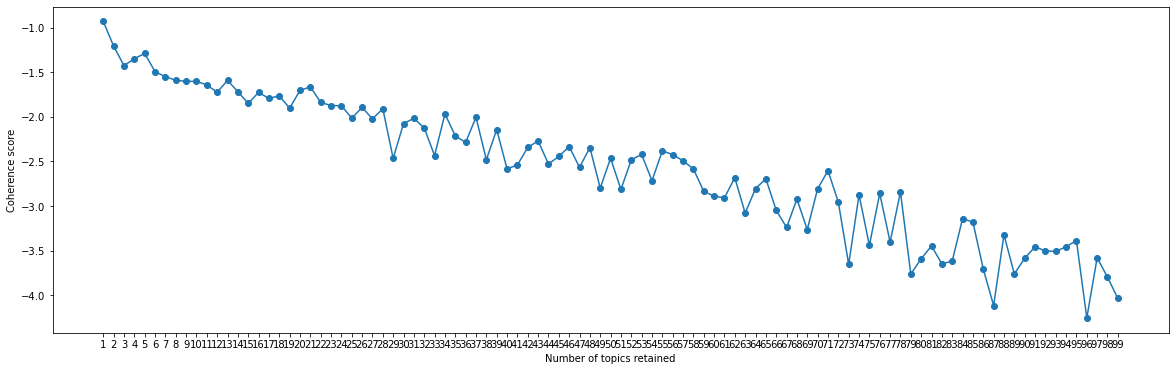

In [15]:
# plot coherence scores
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 100, 1))
plt.show()

In [19]:
# topic model estimation
best_mdl = tp.LDAModel(k=6, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -9.376981115855138
Iteration: 10	Log-likelihood: -9.165132967083652
Iteration: 20	Log-likelihood: -9.018529955486898
Iteration: 30	Log-likelihood: -8.93299417218789
Iteration: 40	Log-likelihood: -8.880746374344088
Iteration: 50	Log-likelihood: -8.844001457007263
Iteration: 60	Log-likelihood: -8.822804994211245
Iteration: 70	Log-likelihood: -8.805778555140419
Iteration: 80	Log-likelihood: -8.79411948533754
Iteration: 90	Log-likelihood: -8.780885049800284


In [23]:
best_mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 10755 docs, 845956 words
| Total Vocabs: 45017, Used Vocabs: 45017
| Entropy of words: 8.10067
| Entropy of term-weighted words: 8.10067
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.78089
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 6 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3625314421 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [1.96483

In [30]:
# prepare data for visualization
topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
vocab = list(best_mdl.used_vocabs)
term_frequency = best_mdl.used_vocab_freq

# visualize the topics
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in 

In [ ]:
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab,term_frequency)


In [ ]:
# word to topic probabilities
# an empty Pandas DF to populate
wt = pd.DataFrame()
# get word probabilities for each topic
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp


# get topic probabilities for each document
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)

### BOW

### Word Embedding

### TF-IDF & Ngrams

In [4]:
import pickle
with open('correct_train.txt','rb') as fp:
  mdy_train = pickle.load(fp)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def simple_logistic_classify(x_train, y_train, x_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('Test Score is', score)
    return model

In [ ]:
# select n-gram
# train model with different n-gram ranges
for N in tqdm.tqdm(range(1,11)):
    vectorizer = TfidfVectorizer(ngram_range=(1,N))
    tfidf_output = vectorizer.fit_transform(tokens_list)
    x = vectorizer.get_feature_names_out()
    # contact the result of tfidf and index
    df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)
    
    # train model and generate predictions
    # split indepedent variable train and validation set
    x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)
    # split dependent varaible 
    y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

    # compute f-1 score
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N), score))



In [ ]:
# apply TFIDF
vectorizer = TfidfVectorizer()
tfidf_output = vectorizer.fit_transform(tokens_list)
x = vectorizer.get_feature_names_out()
print(tfidf_output.shape), vectorizer.get_feature_names_out()

(10755, 44852)


(None, array(['aaaaaaaargh', 'aaaashleeey', 'aaashleeeyjame', ..., 'zwartboek',
        'zwigoff', 'zygalski'], dtype=object))

### Length Analysis 

In [ ]:
df_mdy_train = pd.DataFrame({'imbd_user_review':mdy_train})

In [ ]:
df_mdy_train['word_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: len(x))
df_mdy_train['char_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: sum(len(word) for word in x))
# reviews['sentence_count'] = reviews["imbd_user_review"].apply(lambda x: len(str(x).split(".")))
df_mdy_train['avg_word_length'] = df_mdy_train['char_count'] / df_mdy_train['word_count']
# reviews['avg_sentence_lenght'] = reviews['word_count'] / reviews['sentence_count']
df_mdy_train.head()

,imbd_user_review,word_count,char_count,avg_word_length
0,"[hard, find, delightful, adorable, movie, day,...",64,372,5.812500
1,"[not, film, like, fade, haunt, masterpiece, si...",166,973,5.861446
2,"[view, movie, age, yrsprobably, movie, see, th...",20,121,6.050000
3,"[doubt, i, see, resemble, complete, version, m...",76,508,6.684211
4,"[shocked, find, rivet, movie, doubt, good, sci...",51,287,5.627451


/Users/sunsiyuan/opt/anaconda3/envs/smm750_Dig_tech_Value_cre/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


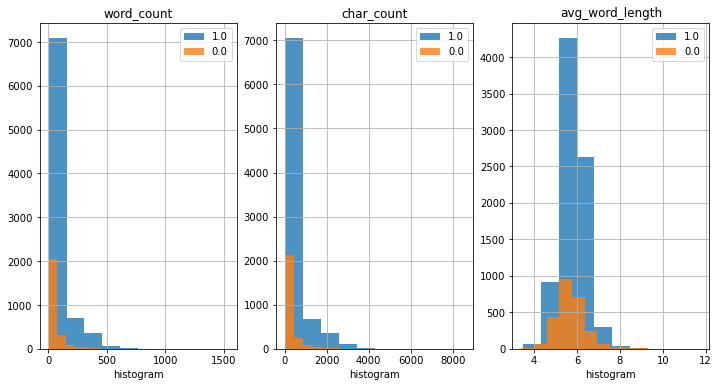

In [ ]:
# visualize the distribution of the dataset
import seaborn as sns
x1,x2,x3,y = "word_count","char_count","avg_word_length", "helpfulness_cat"
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,6))
for i in reviews[y].unique():
    sns.distplot(reviews[reviews[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(reviews[reviews[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(reviews[reviews[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
ax[0].grid(True)
ax[0].legend(reviews[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(reviews[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(reviews[y].unique())
ax[2].set_title("avg_word_length")
plt.show()

### Dimension Reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Use TSNE to reduce the demension to 2
TSNE_model = TSNE(n_components=3, random_state=0)
TSNE_result = TSNE_model.fit_transform(df_tfidfvect)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
TSNE_result_dfm = pd.DataFrame(TSNE_result, columns=['x', 'y','z'])
TSNE_result_dfm.head()

,x,y,z
0,35.296894,33.511894,-18.957975
1,43.665710,28.387058,6.490153
2,-3.823193,5.475380,-1.629816
3,20.880701,10.970266,-16.563936
4,27.041716,7.643130,-22.914478


### Combine features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df3.iloc[:,0:44855] = scaler.fit_transform(df3.iloc[:,0:44855])

In [ ]:
df3 = pd.concat([TSNE_result_dfm, df_mdy_train.iloc[:,1:4]],axis="columns")

In [ ]:
df3.head()

,x,y,z,word_count,char_count,avg_word_length
0,35.296894,33.511894,-18.957975,64,372,5.812500
1,43.665710,28.387058,6.490153,166,973,5.861446
2,-3.823193,5.475380,-1.629816,20,121,6.050000
3,20.880701,10.970266,-16.563936,76,508,6.684211
4,27.041716,7.643130,-22.914478,51,287,5.627451


### Logistic Regression

In [ ]:
# split indepedent variable train and validation set
x_train, x_test = train_test_split(df3, test_size=0.3, random_state=42)

In [ ]:
# split dependent varaible 
y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

In [ ]:
# import packages
from sklearn.linear_model import LogisticRegression

In [ ]:
def simple_logistic_classify(x_train, y_train, x_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('Test Score is', score)
    return model

In [ ]:
model = simple_logistic_classify(x_train, y_train, x_test, y_test)

Test Score is 0.7706848466067555


In [ ]:
# hype-parameter tuning 
from sklearn.model_selection import GridSearchCV
import sklearn
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
# bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)

In [ ]:
# confusion matrix and classification report(precision, recall, F1-score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))
print(confusion_matrix(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.64      0.13      0.22       740
         1.0       0.79      0.98      0.87      2487

    accuracy                           0.78      3227
   macro avg       0.72      0.55      0.55      3227
weighted avg       0.76      0.78      0.72      3227

[[  96  644]
 [  53 2434]]


### Pytorch

In [ ]:
# %%
# load the data

# use one of the toy datasets coming with PyTorch
from torchdata.datapipes.iter import IterableWrapper, FileOpener
import os
def get_name(path_and_stream):
     return os.path.basename(path_and_stream[0]), path_and_stream[1]
 datapipe1 = IterableWrapper(["1.csv", "empty.csv", "empty2.csv"])
 datapipe2 = FileOpener(datapipe1, mode="b")
 datapipe3 = datapipe2.map(get_name)
 csv_parser_dp = datapipe3.parse_csv()
 list(csv_parser_dp)
[['key', 'item'], ['a', '1'], ['b', '2'], []]


# iterator for training data
train_iter = iter(YelpReviewPolarity(split='train'))

# %% 
# inspect the data

# exploit iter
next(train_iter)

# %% 
# buold the vocabulary

# load libraries
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# tokenization
tokenizer = get_tokenizer('basic_english')
train_iter = YelpReviewPolarity(split='train')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# %%
# pre-processing pipelines

# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x) - 1

# %%
# data batches

# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
train_iter = YelpReviewPolarity(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
# %%
# model set up

# examples
train_iter = YelpReviewPolarity(split='train')
# classes
num_class = len(set([label for (label, text) in train_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# %%
# model training and evaluation

# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

# %%
# training - validation split and model run

# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_iter, test_iter = YelpReviewPolarity()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


# %%
# model evaluation

print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

# %%
# test on random unseen review

# labels
review_label = {1: "BAD",
                2: "GOOD"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "."

model = model.to("cpu")

print("This is a %s Yelp reviews" %review_label[predict(ex_text_str, text_pipeline)])